In [1]:
import sys
import time
from time import strftime
import datetime
from calendar import monthrange

import numpy as np
import pandas as pd
import pandas_datareader.data as datareader

import sklearn
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV

import xgboost

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('whitegrid')

%matplotlib inline

random_state = 42
np.random.seed(random_state)

# TODO - do 1-month
# do only the dirt simple and toss everything esle FFS
# think through the 3 month thing, I think I'm regressing with 3 month
# predicting the 3-month
# quintiling
# using 3 months of 1 month if available - make sure not omitting the NAS FFS
# compute Sharpe only with the freaking data after 73
# run full thing end to end

In [2]:
data = pd.read_pickle("data.pickle")
display(data.head())
display(data.tail())

,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3
1016,1963-01-31,1010,25,1.443624,0.126256,0.047002,0.077724
4326,1963-01-31,1040,6,0.448922,-0.477048,0.170732,0.041148
4620,1963-01-31,1043,41,0.255952,-0.390406,0.049505,-0.056931
5016,1963-01-31,1045,40,1.383475,-0.130926,0.102041,0.082269
8419,1963-01-31,1075,31,0.476919,-0.187948,0.060082,-0.002032


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3
2618785,2017-10-31,293884,18,0.181239,0.431529,0.048302,0.157079
2618883,2017-10-31,294524,41,0.246494,0.156449,0.045230,0.122867
2618920,2017-10-31,295786,21,0.291927,0.590161,0.057452,0.115736
2619195,2017-10-31,315318,14,0.936775,0.440197,-0.040359,-0.110314
2619263,2017-10-31,316056,47,0.014658,0.149037,-0.035619,-0.078062


In [3]:
FIRST_TRAIN_MONTHS=120

In [4]:
def convert_datestr(datestr):
    """Convert a beginning of month date string to end of month
    2018-01-01 -> 2018-01-31"""
    year_str, month_str, day_str = datestr.split('-')
    end_of_month = monthrange(int(year_str), int(month_str))[1]
    return "%s-%s-%02d" % (year_str, month_str, end_of_month)

def get_fred_data(series, start_date, end_date):
    retframe = datareader.DataReader(series, "fred", start_date, end_date)
    # convert dates from start to end of month and set index
    retframe['yyyymmdd'] = retframe.index.strftime('%Y-%m-%d')
    retframe['yyyymmdd'] = [convert_datestr(str) for str in retframe['yyyymmdd']]
    retframe['DATETIME'] = pd.to_datetime(retframe['yyyymmdd'])
    retframe.reset_index(inplace=True)
    return retframe[["DATETIME", series]]

start_date = datetime.datetime(1963, 1, 1)
end_date = datetime.datetime(2017, 12, 31)

TB3MS = get_fred_data("TB3MS", start_date, end_date)

# convert discount T-bill rate to monthly YTM
RF=TB3MS.copy()
# YTM
RF["YTM"] = (RF["TB3MS"]/100 * (91/360) + 1) ** (365/91) -1
# Monthly risk-free simple return
RF["RF"]= (1 + RF["YTM"]) ** (1/12) - 1
display(RF.head())
display(RF.tail())

,DATETIME,TB3MS,YTM,RF
0,1963-01-31,2.91,0.029833,0.002453
1,1963-02-28,2.92,0.029936,0.002461
2,1963-03-31,2.89,0.029625,0.002436
3,1963-04-30,2.90,0.029729,0.002444
4,1963-05-31,2.93,0.030040,0.002470


,DATETIME,TB3MS,YTM,RF
655,2017-08-31,1.01,0.010280,0.000853
656,2017-09-30,1.03,0.010484,0.000870
657,2017-10-31,1.07,0.010893,0.000903
658,2017-11-30,1.23,0.012529,0.001038
659,2017-12-31,1.32,0.013451,0.001114


In [51]:
# metrics 

def maxdrawdown(series):
    """max drawdown of a cumulative return series"""
    return (series / series.cummax() -1).min()

# todo: longest period of underperformance, worst vs.index

def portmetrics_monthly(ret, rf):
    "given monthly return, monthly risk-free return as series, return portfolio metrics dataframe"

    annret = (1 + ret).cumprod().iloc[-1] ** (12/len(ret))-1
    print("annualized return: %f" % annret)

    annvol = ret.std() * np.sqrt(12)
    print("annualized volatility: %f" % annvol)

    #annualized excess return
    annexcess = (1 + ret - rf).cumprod().iloc[-1] ** (12/len(ret))-1
    print("annualized excess return: %f" % annexcess)

    # sharpe
    sharpe = annexcess / annvol
    print("Sharpe: %f" % sharpe)

    return pd.DataFrame({"Metric" : ["Annualized return","Annualized volatility","Sharpe"] , 
                         "Value": [annret, annvol, sharpe]})

def sharpe(ret, rf):
    "given monthly return, monthly risk-free return as series, return Sharpe"
    annvol = ret.std() * np.sqrt(12)
    excess_series = 1 + ret - rf
    # cumulative return at end of series
    excess = excess_series.cumprod().iloc[-1] 
    annexcess = excess ** (12/len(ret)) - 1
    sharpe = annexcess / annvol
    return sharpe

def turnover(data):
    """data has gvkeys, datetime, assumed equal weight, datedf = unique dates"""
    datedf = data.groupby("DATETIME").count().reset_index()[["DATETIME","GVKEY"]]
    datedf["EQUALWEIGHT"] = 1/datedf["GVKEY"]
    datedf.head()
    
    turnover_list = []
    for i in range(1, len(datedf["DATETIME"])):
        date0 = datedf["DATETIME"][i-1]
        t0 = data.loc[data["DATETIME"]==date0][["GVKEY", "EQUALWEIGHT"]]

        date1 = datedf["DATETIME"][i]
        t1 = data.loc[data["DATETIME"]==date1][["GVKEY", "EQUALWEIGHT"]]

        turnover_df = t0.merge(t1, on=["GVKEY"], how='outer',suffixes=["_t0","_t1"])    
        turnover_df.fillna(0, inplace=True)
        turnover_list.append(np.abs(turnover_df["EQUALWEIGHT_t0"] - turnover_df["EQUALWEIGHT_t1"]).sum()/2)



In [6]:
# get unique dates
# function to take a dataframe, date, column
#   compute quantile for that date, update quantile column, return dataframe
# loop through dates, call function, accumulate dfs in list, concat

# for each quantile
#   use .loc to select rows in that bucket
#   group by date and average performance by date
#   save performance as a series
# plot 10 series

uniquedates = sorted(data["DATETIME"].unique())
display(uniquedates[:10])
display(uniquedates[-10:])

[numpy.datetime64('1963-01-31T00:00:00.000000000'),
 numpy.datetime64('1963-02-28T00:00:00.000000000'),
 numpy.datetime64('1963-03-31T00:00:00.000000000'),
 numpy.datetime64('1963-04-30T00:00:00.000000000'),
 numpy.datetime64('1963-05-31T00:00:00.000000000'),
 numpy.datetime64('1963-06-30T00:00:00.000000000'),
 numpy.datetime64('1963-07-31T00:00:00.000000000'),
 numpy.datetime64('1963-08-31T00:00:00.000000000'),
 numpy.datetime64('1963-09-30T00:00:00.000000000'),
 numpy.datetime64('1963-10-31T00:00:00.000000000')]

[numpy.datetime64('2017-01-31T00:00:00.000000000'),
 numpy.datetime64('2017-02-28T00:00:00.000000000'),
 numpy.datetime64('2017-03-31T00:00:00.000000000'),
 numpy.datetime64('2017-04-30T00:00:00.000000000'),
 numpy.datetime64('2017-05-31T00:00:00.000000000'),
 numpy.datetime64('2017-06-30T00:00:00.000000000'),
 numpy.datetime64('2017-07-31T00:00:00.000000000'),
 numpy.datetime64('2017-08-31T00:00:00.000000000'),
 numpy.datetime64('2017-09-30T00:00:00.000000000'),
 numpy.datetime64('2017-10-31T00:00:00.000000000')]

In [7]:
num_buckets = 5

def bucket_df_by_col(df, col, num_buckets=num_buckets):
    # compute decile buckets for df.col
    # assign new column col_RANK containing decile bucket for each row
    newcol = col + "_RANK"
    # add a random small num to prevent bucket collisions
    tempvals=df[col] + np.random.uniform(0,0.0000001,len(df))
    # bucket tempcol into num_buckets quantiles
    vals = pd.qcut(tempvals, num_buckets, labels=False)
    df[newcol] = vals
    #df = df.assign(c=col.values)
    return df


In [8]:
dflist = []
for d in uniquedates:
    tempdf = data[data["DATETIME"]==d].copy() # to avoid bucketing on a slice
    dflist.append(bucket_df_by_col(tempdf, "MOMENTUM"))
datanew= pd.concat(dflist)
display(datanew.head())
display(datanew.tail())

,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3,MOMENTUM_RANK
1016,1963-01-31,1010,25,1.443624,0.126256,0.047002,0.077724,4
4326,1963-01-31,1040,6,0.448922,-0.477048,0.170732,0.041148,0
4620,1963-01-31,1043,41,0.255952,-0.390406,0.049505,-0.056931,0
5016,1963-01-31,1045,40,1.383475,-0.130926,0.102041,0.082269,2
8419,1963-01-31,1075,31,0.476919,-0.187948,0.060082,-0.002032,1


,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3,MOMENTUM_RANK
2618785,2017-10-31,293884,18,0.181239,0.431529,0.048302,0.157079,4
2618883,2017-10-31,294524,41,0.246494,0.156449,0.045230,0.122867,2
2618920,2017-10-31,295786,21,0.291927,0.590161,0.057452,0.115736,4
2619195,2017-10-31,315318,14,0.936775,0.440197,-0.040359,-0.110314,4
2619263,2017-10-31,316056,47,0.014658,0.149037,-0.035619,-0.078062,2


,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,5.397779,0.217397,0.022466
1,Quintile 1,10.078869,0.165411,0.301547
2,Quintile 2,10.892780,0.151794,0.379948
3,Quintile 3,11.969714,0.157033,0.433468
4,Quintile 4,15.635759,0.200906,0.514183


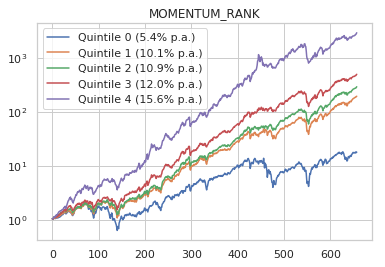

In [9]:
# performance by bucket

col = "MOMENTUM_RANK"

def perf_by_bucket(df, col, rank, perfcol="RET"):
    perf = df.loc[df[col]==rank][["DATETIME", col, perfcol]]\
        .groupby("DATETIME")\
        .mean()\
        .reset_index()
    return perf

reportdict = {'Label': [],
              'Annualized return' : [],
              'Annualized volatility' : [],
              'Sharpe': []}

for i in range(num_buckets):
    tempdf = perf_by_bucket(datanew, col, i, perfcol="RET")
    tempdf["RET1P"] = 1 + (tempdf["RET"])
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    tempdf.reset_index(inplace=True) # so indexes line up with RF
    tempdf["RF"] = RF["RF"]
    
    lastval = list(tempdf["CUMPERF"])[-1]
    
    annret = (lastval**(1/55)-1)*100
    vol = tempdf["CUMPERF"].pct_change().std() * np.sqrt(12)
    
    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    tempdf_sharpe = tempdf.dropna()
    reportdict['Sharpe'].append(sharpe(tempdf_sharpe["RET"], tempdf_sharpe["RF"]))

    tempdf.set_index("DATETIME")
    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));

plt.title(col)
plt.legend();

pd.DataFrame(reportdict)

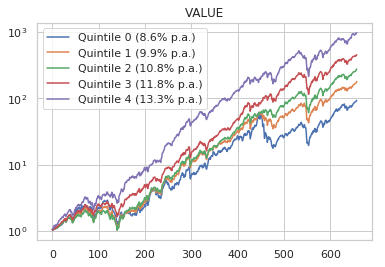

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,8.594235,0.204633,0.173788
1,Quintile 1,9.887269,0.177417,0.270676
2,Quintile 2,10.761397,0.164514,0.343168
3,Quintile 3,11.755163,0.158590,0.416249
4,Quintile 4,13.322785,0.164130,0.493623


In [13]:
def perf_bucket_by_col(data, col, nbuckets=5):

    col_rank = col + "_RANK"

    dflist = []
    for d in uniquedates:
        tempdf = data[data["DATETIME"]==d].copy() # to avoid bucketing on a slice
        dflist.append(bucket_df_by_col(tempdf, col))
    datanew= pd.concat(dflist)

    reportdict = {'Label': [],
                  'Annualized return' : [],
                  'Annualized volatility' : [],
                  'Sharpe': []}

    for i in range(nbuckets):
        
        tempdf = perf_by_bucket(datanew, col_rank, i, perfcol="RET")
        # 1-month signal
        tempdf["RET1P"] = 1 + (tempdf["RET"])
        tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
        tempdf.reset_index(inplace=True) # so indexes line up with RF
        tempdf["RF"] = RF["RF"]

        lastval = list(tempdf["CUMPERF"])[-1]

        annret = (lastval**(1/55)-1)*100
        vol = tempdf["CUMPERF"].pct_change().std() * np.sqrt(12)

        plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));

        reportdict['Label'].append("Quintile %d " % (i))
        reportdict['Annualized return'].append(annret)
        reportdict['Annualized volatility'].append(vol)
        tempdf_sharpe = tempdf.dropna()
        reportdict['Sharpe'].append(sharpe(tempdf_sharpe["RET"], tempdf_sharpe["RF"]))
    
    plt.legend();
    plt.title(col)
    plt.show()

    return pd.DataFrame(reportdict)

col = "VALUE"
perf_bucket_by_col(data, col)


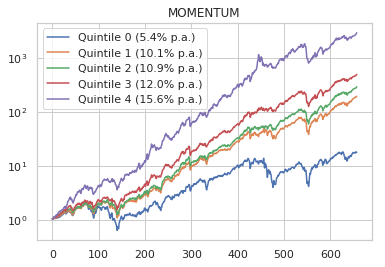

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,5.397454,0.217397,0.022452
1,Quintile 1,10.079228,0.165410,0.301570
2,Quintile 2,10.892780,0.151794,0.379948
3,Quintile 3,11.967228,0.157035,0.433312
4,Quintile 4,15.638306,0.200905,0.514306


In [14]:
perf_bucket_by_col(data, "MOMENTUM")


In [19]:
def perf_bucket_by_col_3(data, col, nbuckets=5, rf=RF, firstmonth=FIRST_TRAIN_MONTHS):
    """Same but put 1/3 of port to work for 3 months"""
    
    data = data.copy()
    data = data.sort_values(["DATETIME", "GVKEY"]).reset_index()
    data["index"]=data.index
    
    dates_df=data[["DATETIME"]].groupby(["DATETIME"]).count()
    dates_df["t0"]=dates_df.index
    dates_df["t1"]=dates_df.shift(-1)["t0"]
    dates_df["t2"]=dates_df.shift(-2)["t0"]

    data["DATETIME1"] = dates_df.loc[data["DATETIME"]]["t1"].values
    data["DATETIME2"] = dates_df.loc[data["DATETIME"]]["t2"].values    

    uniquedates = data[["DATETIME","index"]].groupby("DATETIME").first().reset_index()
    firstindex = uniquedates.iloc[firstmonth,:]["index"]
    print (firstindex)
    print (uniquedates.iloc[firstmonth,1])
    col_rank = col + "_RANK"

    dflist = []
    for d in uniquedates:
        dftemp = data[data["DATETIME"]==d].copy()
        dflist.append(bucket_df_by_col(dftemp, col, nbuckets))
    datanew = pd.concat(dflist)

    
    datanew = datanew.iloc[firstmonth:,:]

    # compute returns by bucket
    reportdict = {'Label': [],
                  'Annualized return' : [],
                  'Annualized volatility' : [],
                  'Sharpe': []}

    for i in range(num_buckets):

        # get returns for this bucket
        T0 = datanew.loc[datanew[col_rank]==i]
        # merge T0 on date +1 to get returns for month 2
        T1 = T0[["DATETIME1", "GVKEY"]].merge(datanew, 
                                              left_on=["DATETIME1", "GVKEY"], 
                                              right_on=["DATETIME", "GVKEY"])[["DATETIME", "GVKEY", "RET"]]
        # month 3
        T2 = T0[["DATETIME2", "GVKEY"]].merge(datanew, 
                                              left_on=["DATETIME2", "GVKEY"], 
                                              right_on=["DATETIME", "GVKEY"])[["DATETIME", "GVKEY", "RET"]]
        # compute means ... every month we put 1/3 portfolio to work for 3 months
        G0 = T0[["DATETIME","RET"]].groupby("DATETIME").mean()
        G1 = T1[["DATETIME","RET"]].groupby("DATETIME").mean()
        G2 = T2[["DATETIME","RET"]].groupby("DATETIME").mean()
        # merge 3 portfolio returns
        G_all = pd.merge(G1,G2,on="DATETIME", how="outer", suffixes=["1", "2"])
        G_all = pd.merge(G_all,G0,on="DATETIME", how="outer") \
            .reset_index() \
            .sort_values("DATETIME") \
            .dropna()
        # average returns by month
        G_all["RET"] = (G_all["RET"] + G_all["RET1"] + G_all["RET2"]) /3
        tempdf = pd.DataFrame(G_all[["DATETIME", "RET"]])

        tempdf["RET1P"] = 1 + tempdf["RET"]
        tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
        tempdf.reset_index(inplace=True)
        tempdf["RF"] = RF["RF"]

        lastval = list(tempdf["CUMPERF"])[-1]
        annret = (lastval**(12/len(tempdf))-1)*100
        vol = tempdf["CUMPERF"].pct_change().std() * np.sqrt(12) * 100

        reportdict['Label'].append("Quintile %d " % (i))
        reportdict['Annualized return'].append(annret)
        reportdict['Annualized volatility'].append(vol)
        tempdf_sharpe = tempdf.dropna()
        reportdict['Sharpe'].append(sharpe(tempdf_sharpe["RET"], tempdf_sharpe["RF"]))

        tempdf.set_index("DATETIME", inplace=True)
        plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));

    plt.legend();
    plt.title(col)
    plt.show()

    with pd.option_context('display.float_format', lambda x: "%.2f" % x):
        display(pd.DataFrame(reportdict))



In [15]:
# dummy variable for financials, enable model to treat them differently, e.g. p/b
data['FINANCIAL'] = 0
data.loc[data["IND_CODE"]==44,"FINANCIAL"] = 1
data.loc[data["IND_CODE"]==45,"FINANCIAL"] = 1
data.loc[data["IND_CODE"]==46,"FINANCIAL"] = 1
data.loc[data["IND_CODE"]==47,"FINANCIAL"] = 1
data.head()

,DATETIME,GVKEY,IND_CODE,VALUE,MOMENTUM,RET,RET3,FINANCIAL
1016,1963-01-31,1010,25,1.443624,0.126256,0.047002,0.077724,0
4326,1963-01-31,1040,6,0.448922,-0.477048,0.170732,0.041148,0
4620,1963-01-31,1043,41,0.255952,-0.390406,0.049505,-0.056931,0
5016,1963-01-31,1045,40,1.383475,-0.130926,0.102041,0.082269,0
8419,1963-01-31,1075,31,0.476919,-0.187948,0.060082,-0.002032,0


In [41]:
data.sort_values(["DATETIME", "GVKEY"], inplace=True)
data.reset_index(inplace=True)
data["index"] = data.index


In [42]:

class BacktestModel():
    
    def __init__(self, 
                 df,
                 create_model=None, 
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 fit_missing=None):

        # 1st column = dates
        # 2nd column = gvkeys
        self.data = df.copy()
        self.data.sort_values(["DATETIME", "GVKEY"], inplace=True)
        self.data.reset_index(inplace=True)
        self.data["index"] = self.data.index
        
        self.uniquedates = self.data[["DATETIME","index"]].groupby("DATETIME").first().reset_index()
        self.uniquedatelist = list(self.uniquedates["index"])
        self.uniquedatedict = dict(zip(self.uniquedates["DATETIME"], 
                                       self.uniquedates["index"]))
        # last column = target
        self.y = df.iloc[:,-1]
        
        # middle = features
        self.X = df.iloc[:,2:-1]
        self.Xrows, self.Xcols = self.X.shape
        
        # create predictions
        self.P = np.zeros_like(self.y)
        
        self.Xscale = self.X.copy()
        self.yscale = self.y.copy()

        if scaler:
            print("scaler: %s " %str(scaler))
            self.Xscale = scaler().fit_transform(self.Xscale)
            self.yscale = scaler().fit_transform(self.yscale)
        
        self.create_model = create_model
        self.startindex = startindex
        self.fit_missing = fit_missing
        
    def fit_predict(self, train_months, predict_months=1, verbose=False):
        """for backtest, train model  
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain months
        train_stop_index = self.uniquedatelist[train_months]
        if verbose:
            print("Training months 0:%d, indexes 0:%d" % (train_months-1, train_stop_index-1))
        X_fit = self.Xscale[:train_stop_index]  # e.g. 0:120
        y_fit = self.yscale[:train_stop_index]

        # train model
        self.model = self.create_model()
        self.model.fit(X_fit, y_fit)

        # predict npredict months (but don't exceed bounds)
        if train_months+predict_months > len(self.uniquedatelist)-1:
            predict_stop_index = len(self.Xscale)
        else:
            predict_stop_index = self.uniquedatelist[train_months+predict_months]
            
        if verbose:
            print("Predicting months %d:%d, indexes %d:%d" % (train_months, train_months+predict_months-1, 
                                                              train_stop_index, predict_stop_index-1))
        X_predict = self.Xscale[train_stop_index:predict_stop_index] # 121-122
        y_predict = self.model.predict(X_predict)
        #print(y_predict)
        self.P[train_stop_index:predict_stop_index] = y_predict
        return self.P
    
    def gen_predictions_regression(self,
                                   step=1, 
                                   splits=None,
                                   verbose=False):
        """predict all months, pass either step (# months) or total # of splits"""
        print("%s Starting training" % (strftime("%H:%M:%S")))

        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, len(self.uniquedatelist), step))
            
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(len(self.uniquedatelist) - month_indexes[-1])
        
        if verbose:
            print ("Months: " + str(month_indexes))
            print ("Steps: " + str(steps))

        progress_i = 0
            
        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d months (%d:%d), storing predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            predictions = self.fit_predict(month_index, forecast_rows, verbose=verbose)
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")    
        print("%s Finished training" % (strftime("%H:%M:%S")))


In [43]:
backtestmodel = BacktestModel(data[['DATETIME', 'FINANCIAL', 'GVKEY', 'MOMENTUM', 'VALUE', 'RET3']],
                              create_model=LinearRegression,
                              startindex=FIRST_TRAIN_MONTHS,
                             )

backtestmodel.gen_predictions_regression(verbose=False)

22:00:02 Starting training
................................................................................
22:00:02 Still training step 80 of 538
................................................................................
22:00:03 Still training step 160 of 538
................................................................................
22:00:04 Still training step 240 of 538
................................................................................
22:00:05 Still training step 320 of 538
................................................................................
22:00:06 Still training step 400 of 538
................................................................................
22:00:07 Still training step 480 of 538
..........................................................
22:00:08 Finished training


In [44]:
data2 = backtestmodel.data.copy()
data2["RET"] = data["RET"]
data2["P"] = backtestmodel.P

# map dates to first row
dateindexes = data2.groupby(["DATETIME"])["index"].first()

data2 = data2.iloc[dateindexes[120]:,:]

data2.head()

,index,DATETIME,FINANCIAL,GVKEY,MOMENTUM,VALUE,RET3,RET,P
66484,66484,1973-01-31,0,1010,-0.010382,1.044125,-0.035879,-0.060367,0.032884
66485,66485,1973-01-31,0,1040,0.147918,0.215630,-0.426136,-0.336343,0.017207
66486,66486,1973-01-31,0,1043,0.125996,0.600845,-0.381818,-0.166667,0.024996
66487,66487,1973-01-31,0,1045,-0.331288,0.835086,-0.194030,-0.223881,0.025419
66488,66488,1973-01-31,0,1075,0.246193,1.047037,-0.129671,-0.040000,0.035429


In [54]:
# bucket predictions, put into PREDRANK
data3 = None
for d in dateindexes.index[FIRST_TRAIN_MONTHS:]:
    tempdf = data2.loc[data["DATETIME"]==d]
#    print(d, len(tempdf))
    tempdf["PREDRANK"] = pd.qcut(tempdf["P"], num_buckets, labels=False)
    if data3 is None:
        data3 = tempdf
    else:
        data3 = pd.concat([data3, tempdf])
        
data3.head()

data3.to_pickle('lr_regression_predict_buckets.pickle')
data3.head()


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,index,DATETIME,FINANCIAL,GVKEY,MOMENTUM,VALUE,RET3,RET,P,PREDRANK
164394,164394,1983-01-31,0,1040,-0.316815,1.364249,0.011510,0.030534,0.034255,2
164395,164395,1983-01-31,0,1045,0.943182,1.596511,0.055556,-0.121212,0.063793,4
164396,164396,1983-01-31,0,1075,0.334928,1.082202,0.025584,0.036103,0.038684,2
164397,164397,1983-01-31,0,1078,0.453428,0.350923,0.115449,0.047355,0.021143,0
164398,164398,1983-01-31,0,1161,1.127660,0.368525,0.333333,0.432836,0.034073,2


In [55]:
data3=pd.read_pickle('lr_regression_predict_buckets.pickle')
# create dataframe of all the dates
dates_df = pd.DataFrame(dateindexes)
dates_df["t0"]=dates_df.index
dates_df["t1"]=dates_df.shift(-1)["t0"]
dates_df["t2"]=dates_df.shift(-2)["t0"]

dateindexes = data3.groupby(["DATETIME"])["index"].first()
dateindexes.head()


DATETIME
1983-01-31    164394
1983-02-28    165167
1983-03-31    165942
1983-04-30    166725
1983-05-31    167498
Name: index, dtype: int64

In [56]:
# store t+1 and t+2 in data3
data3["DATETIME1"] = dates_df.loc[data3["DATETIME"]]["t1"].values
data3["DATETIME2"] = dates_df.loc[data3["DATETIME"]]["t2"].values

In [57]:
display(data3.head())
display(data3.tail())

,index,DATETIME,FINANCIAL,GVKEY,MOMENTUM,VALUE,RET3,RET,P,PREDRANK,DATETIME1,DATETIME2
164394,164394,1983-01-31,0,1040,-0.316815,1.364249,0.011510,0.030534,0.034255,2,1983-02-28,1983-03-31
164395,164395,1983-01-31,0,1045,0.943182,1.596511,0.055556,-0.121212,0.063793,4,1983-02-28,1983-03-31
164396,164396,1983-01-31,0,1075,0.334928,1.082202,0.025584,0.036103,0.038684,2,1983-02-28,1983-03-31
164397,164397,1983-01-31,0,1078,0.453428,0.350923,0.115449,0.047355,0.021143,0,1983-02-28,1983-03-31
164398,164398,1983-01-31,0,1161,1.127660,0.368525,0.333333,0.432836,0.034073,2,1983-02-28,1983-03-31


,index,DATETIME,FINANCIAL,GVKEY,MOMENTUM,VALUE,RET3,RET,P,PREDRANK,DATETIME1,DATETIME2
574585,574585,2017-10-31,0,293884,0.431529,0.181239,0.157079,0.048302,0.013719,0,NaT,NaT
574586,574586,2017-10-31,0,294524,0.156449,0.246494,0.122867,0.045230,0.012717,0,NaT,NaT
574587,574587,2017-10-31,0,295786,0.590161,0.291927,0.115736,0.057452,0.016827,0,NaT,NaT
574588,574588,2017-10-31,0,315318,0.440197,0.936775,-0.110314,-0.040359,0.026303,3,NaT,NaT
574589,574589,2017-10-31,1,316056,0.149037,0.014658,-0.078062,-0.035619,0.007756,0,NaT,NaT


In [ ]:

reportdict = {'Label': [],
              'Annualized return' : [],
              'Annualized volatility' : [],
              'Sharpe': []}

for i in range(num_buckets):

    # get returns for this bucket
    T0 = data3.loc[data3["PREDRANK"]==i]
    # get returns for t+1
    # inner join, note some stocks will not have returns for t+1
    # corp action or possibly also excluded by mkt cap filter
    T1 = T0[["DATETIME1", "GVKEY"]].merge(data3, how='left',
                                          left_on=["DATETIME1", "GVKEY"], 
                                          right_on=["DATETIME", "GVKEY"])[["DATETIME", "GVKEY", "RET"]]
    T2 = T0[["DATETIME2", "GVKEY"]].merge(data3, how='left',
                                          left_on=["DATETIME2", "GVKEY"], 
                                          right_on=["DATETIME", "GVKEY"])[["DATETIME", "GVKEY", "RET"]]
    T2.sort_values(['DATETIME', 'GVKEY']).tail()
    
    G0 = T0[["DATETIME","RET"]].groupby("DATETIME").mean()
    G1 = T1[["DATETIME","RET"]].groupby("DATETIME").mean()
    G2 = T2[["DATETIME","RET"]].groupby("DATETIME").mean()
    G_all = pd.merge(G1,G2,on="DATETIME", how="outer", suffixes=["1", "2"])
    G_all = pd.merge(G_all,G0,on="DATETIME", how="outer") \
        .sort_values("DATETIME") \
        .reset_index() 
    # average returns by month
    G_all = G_all.fillna(value=0) # otherwise only 1/3 of portfolio at work 1st month + 2 NAs = NA
    G_all["RET"] = (G_all["RET"] + G_all["RET1"] + G_all["RET2"]) /3
    
    # compute cumulative return
    tempdf = pd.DataFrame(G_all[["DATETIME", "RET"]])

    tempdf["RET1P"] = 1 + tempdf["RET"]
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    tempdf.reset_index(inplace=True)
    tempdf["RF"] = RF["RF"]

    lastval = list(tempdf["CUMPERF"])[-1]
    annret = (lastval**(12/len(tempdf))-1)*100
    vol = tempdf["CUMPERF"].pct_change().std() * np.sqrt(12) * 100

    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    tempdf_sharpe = tempdf.dropna()
    reportdict['Sharpe'].append(sharpe(tempdf_sharpe["RET"], tempdf_sharpe["RF"]))

    tempdf.set_index("DATETIME", inplace=True)
    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));

plt.legend();
plt.title("LINEAR REGRESSION")
plt.show()

with pd.option_context('display.float_format', lambda x: "%.2f" % x):
    display(pd.DataFrame(reportdict))
  

In [59]:
#XGBoost

n_estimators = 300
max_depth = 14
subsample = 0.7
colsample_bytree = 1/3
learning_rate = 0.1
gamma = 0

def my_create_model():
    return xgboost.XGBRegressor(n_estimators = n_estimators,
                                max_depth = max_depth,
                                subsample = subsample,
                                colsample_bytree = colsample_bytree,
                                learning_rate = learning_rate,
                                gamma = gamma
                               )

backtestmodel = BacktestModel(data[['DATETIME', 'GVKEY', 'FINANCIAL', 'MOMENTUM', 'VALUE', 'RET3']],
                              create_model=my_create_model,
                              startindex=FIRST_TRAIN_MONTHS)

backtestmodel.gen_predictions_regression(verbose=False)

22:10:30 Starting training
................................................................................
22:19:43 Still training step 80 of 538
................................................................................
22:35:33 Still training step 160 of 538
................................................................................
22:58:26 Still training step 240 of 538
................................................................................
23:30:06 Still training step 320 of 538
................................................................................
00:12:47 Still training step 400 of 538
..............................................................................
01:05:22 Still training step 480 of 538
..........................................................
01:50:53 Finished training


In [64]:
data2 = backtestmodel.data.copy()
data2['RET'] = data['RET']
data2['P'] = backtestmodel.P
data2.head()

,index,DATETIME,GVKEY,FINANCIAL,MOMENTUM,VALUE,RET3,RET,P
0,0,1963-01-31,1010,0,0.126256,1.443624,0.077724,0.047002,0.0
1,1,1963-01-31,1040,0,-0.477048,0.448922,0.041148,0.170732,0.0
2,2,1963-01-31,1043,0,-0.390406,0.255952,-0.056931,0.049505,0.0
3,3,1963-01-31,1045,0,-0.130926,1.383475,0.082269,0.102041,0.0
4,4,1963-01-31,1075,0,-0.187948,0.476919,-0.002032,0.060082,0.0


In [66]:
dateindexes = data2.groupby(["DATETIME"])["index"].first()
dateindexes

DATETIME
1963-01-31         0
1963-02-28       402
1963-03-31       818
1963-04-30      1228
1963-05-31      1637
1963-06-30      2040
1963-07-31      2458
1963-08-31      2893
1963-09-30      3342
1963-10-31      3805
1963-11-30      4266
1963-12-31      4734
1964-01-31      5193
1964-02-29      5659
1964-03-31      6126
1964-04-30      6590
1964-05-31      7056
1964-06-30      7520
1964-07-31      7984
1964-08-31      8452
1964-09-30      8929
1964-10-31      9400
1964-11-30      9872
1964-12-31     10353
1965-01-31     10828
1965-02-28     11308
1965-03-31     11788
1965-04-30     12275
1965-05-31     12760
1965-06-30     13250
               ...  
2015-05-31    543367
2015-06-30    544402
2015-07-31    545462
2015-08-31    546563
2015-09-30    547674
2015-10-31    548787
2015-11-30    549823
2015-12-31    550879
2016-01-31    551985
2016-02-29    553113
2016-03-31    554172
2016-04-30    555173
2016-05-31    556194
2016-06-30    557218
2016-07-31    558267
2016-08-31    559285
2016

In [67]:
# bucket predictions, put into PREDRANK
data3 = None
for d in dateindexes.index[120:]:
    tempdf = data2.loc[data2["DATETIME"]==d]
    print(d, len(tempdf))
    tempdf["PREDRANK"] = pd.qcut(tempdf["P"], num_buckets, labels=False)
    if data3 is None:
        data3 = tempdf
    else:
        data3 = pd.concat([data3, tempdf])
data3.head()

1973-01-31 00:00:00 737
1973-02-28 00:00:00 748
1973-03-31 00:00:00 726
1973-04-30 00:00:00 734
1973-05-31 00:00:00 740


/home/ubuntu/anaconda2/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1973-06-30 00:00:00 733
1973-07-31 00:00:00 687
1973-08-31 00:00:00 732
1973-09-30 00:00:00 685
1973-10-31 00:00:00 735
1973-11-30 00:00:00 808
1973-12-31 00:00:00 732
1974-01-31 00:00:00 839
1974-02-28 00:00:00 862
1974-03-31 00:00:00 873
1974-04-30 00:00:00 909
1974-05-31 00:00:00 902
1974-06-30 00:00:00 891
1974-07-31 00:00:00 901
1974-08-31 00:00:00 920
1974-09-30 00:00:00 919
1974-10-31 00:00:00 819
1974-11-30 00:00:00 900
1974-12-31 00:00:00 894
1975-01-31 00:00:00 756
1975-02-28 00:00:00 837
1975-03-31 00:00:00 821
1975-04-30 00:00:00 835
1975-05-31 00:00:00 826
1975-06-30 00:00:00 809
1975-07-31 00:00:00 873
1975-08-31 00:00:00 861
1975-09-30 00:00:00 866
1975-10-31 00:00:00 840
1975-11-30 00:00:00 829
1975-12-31 00:00:00 846
1976-01-31 00:00:00 779
1976-02-29 00:00:00 823
1976-03-31 00:00:00 833
1976-04-30 00:00:00 842
1976-05-31 00:00:00 849
1976-06-30 00:00:00 810
1976-07-31 00:00:00 832
1976-08-31 00:00:00 850
1976-09-30 00:00:00 824
1976-10-31 00:00:00 848
1976-11-30 00:00

2001-09-30 00:00:00 1190
2001-10-31 00:00:00 1020
2001-11-30 00:00:00 1018
2001-12-31 00:00:00 1053
2002-01-31 00:00:00 1097
2002-02-28 00:00:00 1047
2002-03-31 00:00:00 997
2002-04-30 00:00:00 1027
2002-05-31 00:00:00 1038
2002-06-30 00:00:00 1047
2002-07-31 00:00:00 1095
2002-08-31 00:00:00 1005
2002-09-30 00:00:00 1081
2002-10-31 00:00:00 992
2002-11-30 00:00:00 982
2002-12-31 00:00:00 1052
2003-01-31 00:00:00 1035
2003-02-28 00:00:00 1039
2003-03-31 00:00:00 1016
2003-04-30 00:00:00 964
2003-05-31 00:00:00 978
2003-06-30 00:00:00 1013
2003-07-31 00:00:00 1005
2003-08-31 00:00:00 1015
2003-09-30 00:00:00 1026
2003-10-31 00:00:00 989
2003-11-30 00:00:00 1022
2003-12-31 00:00:00 1009
2004-01-31 00:00:00 1018
2004-02-29 00:00:00 1015
2004-03-31 00:00:00 1025
2004-04-30 00:00:00 1034
2004-05-31 00:00:00 1006
2004-06-30 00:00:00 978
2004-07-31 00:00:00 1057
2004-08-31 00:00:00 1005
2004-09-30 00:00:00 981
2004-10-31 00:00:00 986
2004-11-30 00:00:00 943
2004-12-31 00:00:00 990
2005-01-31 

,index,DATETIME,GVKEY,FINANCIAL,MOMENTUM,VALUE,RET3,RET,P,PREDRANK
66484,66484,1973-01-31,1010,0,-0.010382,1.044125,-0.035879,-0.060367,0.002573,1
66485,66485,1973-01-31,1040,0,0.147918,0.215630,-0.426136,-0.336343,0.003385,1
66486,66486,1973-01-31,1043,0,0.125996,0.600845,-0.381818,-0.166667,-0.045810,0
66487,66487,1973-01-31,1045,0,-0.331288,0.835086,-0.194030,-0.223881,0.008372,1
66488,66488,1973-01-31,1075,0,0.246193,1.047037,-0.129671,-0.040000,0.021384,2


In [68]:
data3.to_pickle('regressionxgb_predict_buckets.pickle')
data3.head()


,index,DATETIME,GVKEY,FINANCIAL,MOMENTUM,VALUE,RET3,RET,P,PREDRANK
66484,66484,1973-01-31,1010,0,-0.010382,1.044125,-0.035879,-0.060367,0.002573,1
66485,66485,1973-01-31,1040,0,0.147918,0.215630,-0.426136,-0.336343,0.003385,1
66486,66486,1973-01-31,1043,0,0.125996,0.600845,-0.381818,-0.166667,-0.045810,0
66487,66487,1973-01-31,1045,0,-0.331288,0.835086,-0.194030,-0.223881,0.008372,1
66488,66488,1973-01-31,1075,0,0.246193,1.047037,-0.129671,-0.040000,0.021384,2


In [74]:
# we predicted 3-month returns
# for all the 1s, we will collect this month's return + next 2 months, to hold for 3 months [datetime, gvkey, return, monthno]

# for now, store the DATES values as extra columns in data3
data3=pd.read_pickle('regressionxgb_predict_buckets.pickle')
# create dataframe of all the dates
dates_df = pd.DataFrame(dateindexes)
dates_df["t0"]=dates_df.index
dates_df["t1"]=dates_df.shift(-1)["t0"]
dates_df["t2"]=dates_df.shift(-2)["t0"]

In [75]:
dates_df.head()

,index,t0,t1,t2
DATETIME,,,,
1963-01-31,0,1963-01-31,1963-02-28,1963-03-31
1963-02-28,402,1963-02-28,1963-03-31,1963-04-30
1963-03-31,818,1963-03-31,1963-04-30,1963-05-31
1963-04-30,1228,1963-04-30,1963-05-31,1963-06-30
1963-05-31,1637,1963-05-31,1963-06-30,1963-07-31


In [76]:
# store t+1 and t+2 in data3
data3["DATETIME1"] = dates_df.loc[data3["DATETIME"]]["t1"].values
data3["DATETIME2"] = dates_df.loc[data3["DATETIME"]]["t2"].values


In [77]:
display(data3.head())
display(data3.tail())

,index,DATETIME,GVKEY,FINANCIAL,MOMENTUM,VALUE,RET3,RET,P,PREDRANK,DATETIME1,DATETIME2
66484,66484,1973-01-31,1010,0,-0.010382,1.044125,-0.035879,-0.060367,0.002573,1,1973-02-28,1973-03-31
66485,66485,1973-01-31,1040,0,0.147918,0.215630,-0.426136,-0.336343,0.003385,1,1973-02-28,1973-03-31
66486,66486,1973-01-31,1043,0,0.125996,0.600845,-0.381818,-0.166667,-0.045810,0,1973-02-28,1973-03-31
66487,66487,1973-01-31,1045,0,-0.331288,0.835086,-0.194030,-0.223881,0.008372,1,1973-02-28,1973-03-31
66488,66488,1973-01-31,1075,0,0.246193,1.047037,-0.129671,-0.040000,0.021384,2,1973-02-28,1973-03-31


,index,DATETIME,GVKEY,FINANCIAL,MOMENTUM,VALUE,RET3,RET,P,PREDRANK,DATETIME1,DATETIME2
574585,574585,2017-10-31,293884,0,0.431529,0.181239,0.157079,0.048302,0.037687,4,NaT,NaT
574586,574586,2017-10-31,294524,0,0.156449,0.246494,0.122867,0.045230,0.045877,4,NaT,NaT
574587,574587,2017-10-31,295786,0,0.590161,0.291927,0.115736,0.057452,0.020437,1,NaT,NaT
574588,574588,2017-10-31,315318,0,0.440197,0.936775,-0.110314,-0.040359,0.035020,3,NaT,NaT
574589,574589,2017-10-31,316056,1,0.149037,0.014658,-0.078062,-0.035619,0.023780,1,NaT,NaT


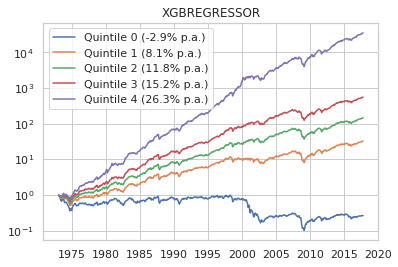

,Label,Annualized return,Annualized volatility,Sharpe
0,Quintile 0,-2.93,21.07,-0.40
1,Quintile 1,8.08,16.78,0.12
2,Quintile 2,11.77,15.94,0.35
3,Quintile 3,15.15,15.60,0.56
4,Quintile 4,26.32,18.88,1.03


In [78]:
# compute returns by bucket
# calculate sharpe

reportdict = {'Label': [],
              'Annualized return' : [],
              'Annualized volatility' : [],
              'Sharpe': []}

for i in range(num_buckets):

    # get returns for this bucket
    T0 = data3.loc[data3["PREDRANK"]==i]
    # get returns for t+1
    # inner join, note some stocks will not have returns for t+1
    # corp action or possibly also excluded by mkt cap filter
    T1 = T0[["DATETIME1", "GVKEY"]].merge(data3, how='left',
                                          left_on=["DATETIME1", "GVKEY"], 
                                          right_on=["DATETIME", "GVKEY"])[["DATETIME", "GVKEY", "RET"]]
    T2 = T0[["DATETIME2", "GVKEY"]].merge(data3, how='left',
                                          left_on=["DATETIME2", "GVKEY"], 
                                          right_on=["DATETIME", "GVKEY"])[["DATETIME", "GVKEY", "RET"]]
    T2.sort_values(['DATETIME', 'GVKEY']).tail()
    
    G0 = T0[["DATETIME","RET"]].groupby("DATETIME").mean()
    G1 = T1[["DATETIME","RET"]].groupby("DATETIME").mean()
    G2 = T2[["DATETIME","RET"]].groupby("DATETIME").mean()
    G_all = pd.merge(G1,G2,on="DATETIME", how="outer", suffixes=["1", "2"])
    G_all = pd.merge(G_all,G0,on="DATETIME", how="outer") \
        .sort_values("DATETIME") \
        .reset_index() 
    # average returns by month
    G_all = G_all.fillna(value=0) # otherwise only 1/3 of portfolio at work 1st month + 2 NAs = NA
    G_all["RET"] = (G_all["RET"] + G_all["RET1"] + G_all["RET2"]) /3
    
    # compute cumulative return
    tempdf = pd.DataFrame(G_all[["DATETIME", "RET"]])

    tempdf["RET1P"] = 1 + tempdf["RET"]
    tempdf["CUMPERF"] = tempdf["RET1P"].cumprod()
    tempdf.reset_index(inplace=True)
    tempdf["RF"] = RF["RF"]

    lastval = list(tempdf["CUMPERF"])[-1]
    annret = (lastval**(12/len(tempdf))-1)*100
    vol = tempdf["CUMPERF"].pct_change().std() * np.sqrt(12) * 100

    reportdict['Label'].append("Quintile %d " % (i))
    reportdict['Annualized return'].append(annret)
    reportdict['Annualized volatility'].append(vol)
    tempdf_sharpe = tempdf.dropna()
    reportdict['Sharpe'].append(sharpe(tempdf_sharpe["RET"], tempdf_sharpe["RF"]))

    tempdf.set_index("DATETIME", inplace=True)
    plt.semilogy(tempdf['CUMPERF'], label="Quintile %d (%.1f%% p.a.)" % (i, annret));

plt.legend();
plt.title("XGBREGRESSOR")
plt.show()

with pd.option_context('display.float_format', lambda x: "%.2f" % x):
    display(pd.DataFrame(reportdict))
    